<a href="https://colab.research.google.com/github/mladbago/podstawy_sztucznej_inteligencji/blob/main/Z11_I_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

print(keras.__version__)

from numpy.random import seed
seed(123)


2.0.0-rc1
2.2.4-tf


In [1]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('https://raw.githubusercontent.com/mladbago/podstawy_sztucznej_inteligencji/main/Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('https://raw.githubusercontent.com/mladbago/podstawy_sztucznej_inteligencji/main/Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

<ipython-input-1-d866d9954fc4>:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_set = pd.read_csv('https://raw.githubusercontent.com/mladbago/podstawy_sztucznej_inteligencji/main/Dane/adult/adult.data', sep=", ",header = None)
<ipython-input-1-d866d9954fc4>:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_set = pd.read_csv('https://raw.githubusercontent.com/mladbago/podstawy_sztucznej_inteligencji/main/Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [2]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(50,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(10,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="Adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, early_stopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4200      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

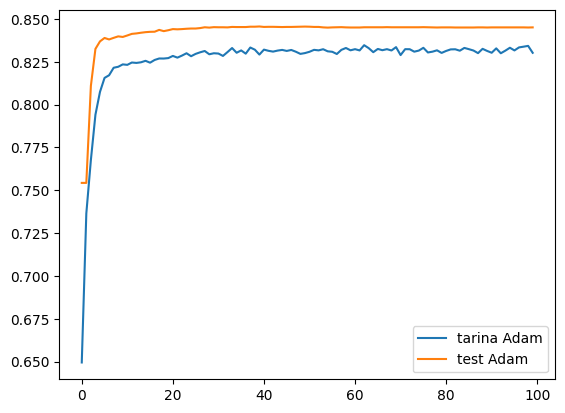

In [4]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

# Zad.
Do poniższego modelu dodaj
```python
model.add(Dropout(0.8))
```
w każdej warstwie.

Zwizualizuj wyniki:

* porównaj krzywe uczenia
* narysuj granice decyzyjne (dane są w 2D)

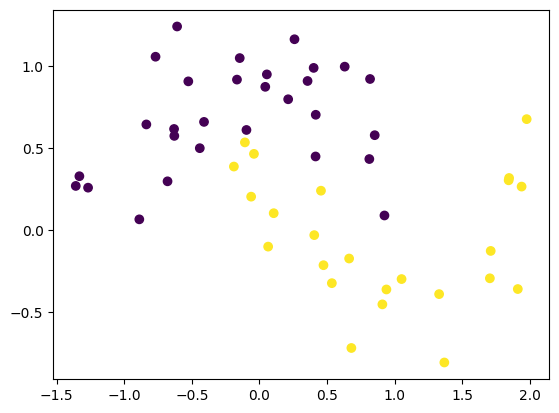

In [5]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [6]:
from keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              3000      
                                                                 
 dense_5 (Dense)             (None, 500)               500500    
                                                                 
 dense_6 (Dense)             (None, 200)               100200    
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 2s 346ms/step - loss: 0.6931 - accuracy: 0.5472 - val_loss: 0.8772 - val_accuracy: 0.4468
Epoch 2/1000
2/2 [====================

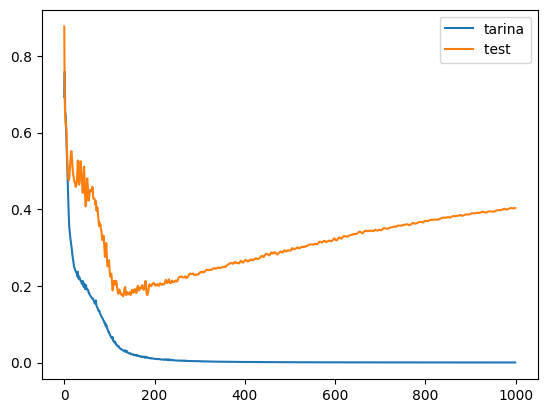

In [7]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

9600/9600 [==============================] - 26s 3ms/step


TypeError: ignored

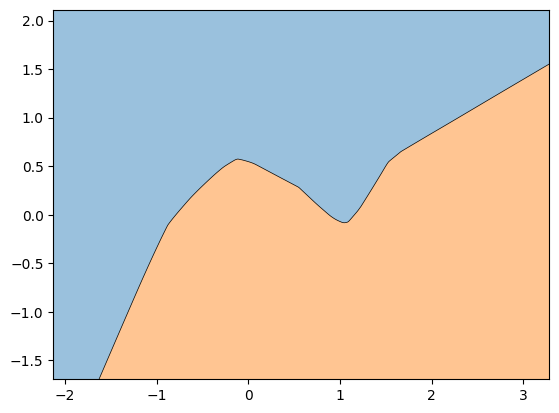

In [8]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

# Zad.
Do poniższego modelu dodaj
 
```python
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
```

w każdej warstwie.

Zwizualizuj wyniki:

* porównaj krzywe uczenia
* narysuj granice decyzyjne (dane są w 2D)
* porównaj do powyższego eksperymentu

In [11]:
from keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(500,activation="sigmoid"))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(200,activation="sigmoid"))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(1,activation="sigmoid"))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


NameError: ignored

In [ ]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

In [ ]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

# Regularyzacja

# Zad.
Do modelu dodaj 
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.0001)))
```

* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.0001)))
```

w każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

In [10]:
from keras.callbacks import History
from tensorflow.keras.layers import BatchNormalization

history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(500,activation="sigmoid"))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(200,activation="sigmoid"))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(1,activation="sigmoid"))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


NameError: ignored

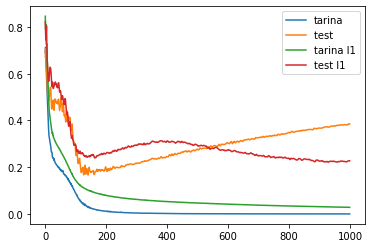

In [ ]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

# plt.plot(history_Adam_1.history['loss'], label = "tarina dropout")
# plt.plot(history_Adam_1.history['val_loss'], label = "test dropout")

plt.plot(history_Adam_2.history['loss'], label = "tarina l1")
plt.plot(history_Adam_2.history['val_loss'], label = "test l1")

plt.legend()
plt.show()

In [ ]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()